In [32]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact

import pandas as pd
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Question 1

During your internship at EPCOR, you are given a dataset containing 10,000 observations of monthly utility bills (in Canadian dollars) for Edmonton houses over the last couple of years. Along with the monthly bill, you are also given:

- `avg_temperature`: the average temperature during the billing month (in Celsius).
- `household_size`: the number of people living in the house during the billing month.
- `house_taxes`: the yearly property taxes according to the last tax notice (in Canadian dollars).

Under the consent of residents, the City of Edmonton kindly provided household and taxes information for the dataset. This information was matched, but it's not perfect.

Your goal is to determine whether the utility bill amount can be predicted using the other three variables.

## A (15 points)

Load the data from the file `EPCOR1.csv` (link provided below) into a Pandas DataFrame. Clean the data by removing any corrupted values.

Do you think using mean imputation is a better approach to deal with corrupted observations in this case? Explain.

In [109]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/Epcor1.csv'
data = pd.read_csv(path_to_data)
display(data.describe())
data

,avg_temperature,household_size,house_taxes,bill
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.261718,2.098500,4107.637598,310.312478
std,8.226165,1.175388,6314.119179,13.754624
min,-25.774117,0.000000,682.060000,287.571982
25%,-1.410821,1.000000,2718.060000,300.194427
50%,4.249438,2.000000,3613.900000,307.332263
75%,9.875206,3.000000,4519.920000,317.376281
max,38.480774,8.000000,99999.000000,446.639790


,avg_temperature,household_size,house_taxes,bill
0,21.083807,4,2341.40,339.825365
1,17.945661,2,4061.82,317.335924
2,10.818872,1,2616.26,304.327370
3,26.491015,1,4835.50,316.291108
4,0.811429,3,5853.50,308.869530
...,...,...,...,...
9995,9.195303,1,5629.54,295.463720
9996,-5.014737,2,4041.46,308.811366
9997,9.263699,3,3634.26,300.816582
9998,3.120226,2,3786.96,299.321222


In [110]:
data2 = data.loc[data['house_taxes'] == 99999]
display(data2.describe())
#removed taxes at 99999 and households at 0 as those are corrupted and cannot occur
data.loc[data['house_taxes'] == 99999, 'house_taxes'] = data.loc[data['house_taxes'] != 99999, 'house_taxes'].mean()
data.loc[data['household_size'] == 0, 'household_size'] = data.loc[data['household_size'] != 0, 'household_size'].mean()
display(data.describe())

#Reviewing the data, the corrupted taxes entries result from too many decimal places, causing the data to diesplay as 99999. A much better method would have been to round the decimals,
#as it seems to be a division issue causing too many decimals, and the rounded to 2 decimal value seems correct.
#For household size there is no better option, as 0 house size cannot exist. We cannot tell what size would be better, so using mean imputation is the best option.

,avg_temperature,household_size,house_taxes,bill
count,41.000000,41.000000,41.0,41.000000
mean,3.820627,2.121951,99999.0,308.665960
std,8.599801,1.122389,0.0,11.583652
min,-13.953509,0.000000,99999.0,291.158458
25%,-1.087990,1.000000,99999.0,300.016359
50%,3.998413,2.000000,99999.0,304.934159
75%,9.439284,3.000000,99999.0,315.883404
max,18.381333,5.000000,99999.0,345.590065


<ipython-input-110-5bcc5d85224a>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.2161791107825537' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['household_size'] == 0, 'household_size'] = data.loc[data['household_size'] != 0, 'household_size'].mean()


,avg_temperature,household_size,house_taxes,bill
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.261718,2.216179,3712.864442,310.312478
std,8.226165,1.065158,1417.384687,13.754624
min,-25.774117,1.000000,682.060000,287.571982
25%,-1.410821,1.000000,2718.060000,300.194427
50%,4.249438,2.000000,3613.900000,307.332263
75%,9.875206,3.000000,4499.560000,317.376281
max,38.480774,8.000000,13641.200000,446.639790


## B (10 points)

Create scatter plots for the utility bill versus the average temperature and the property taxes in different subplots within the same figure.

Text(0.5, 0, 'Tax ($)')

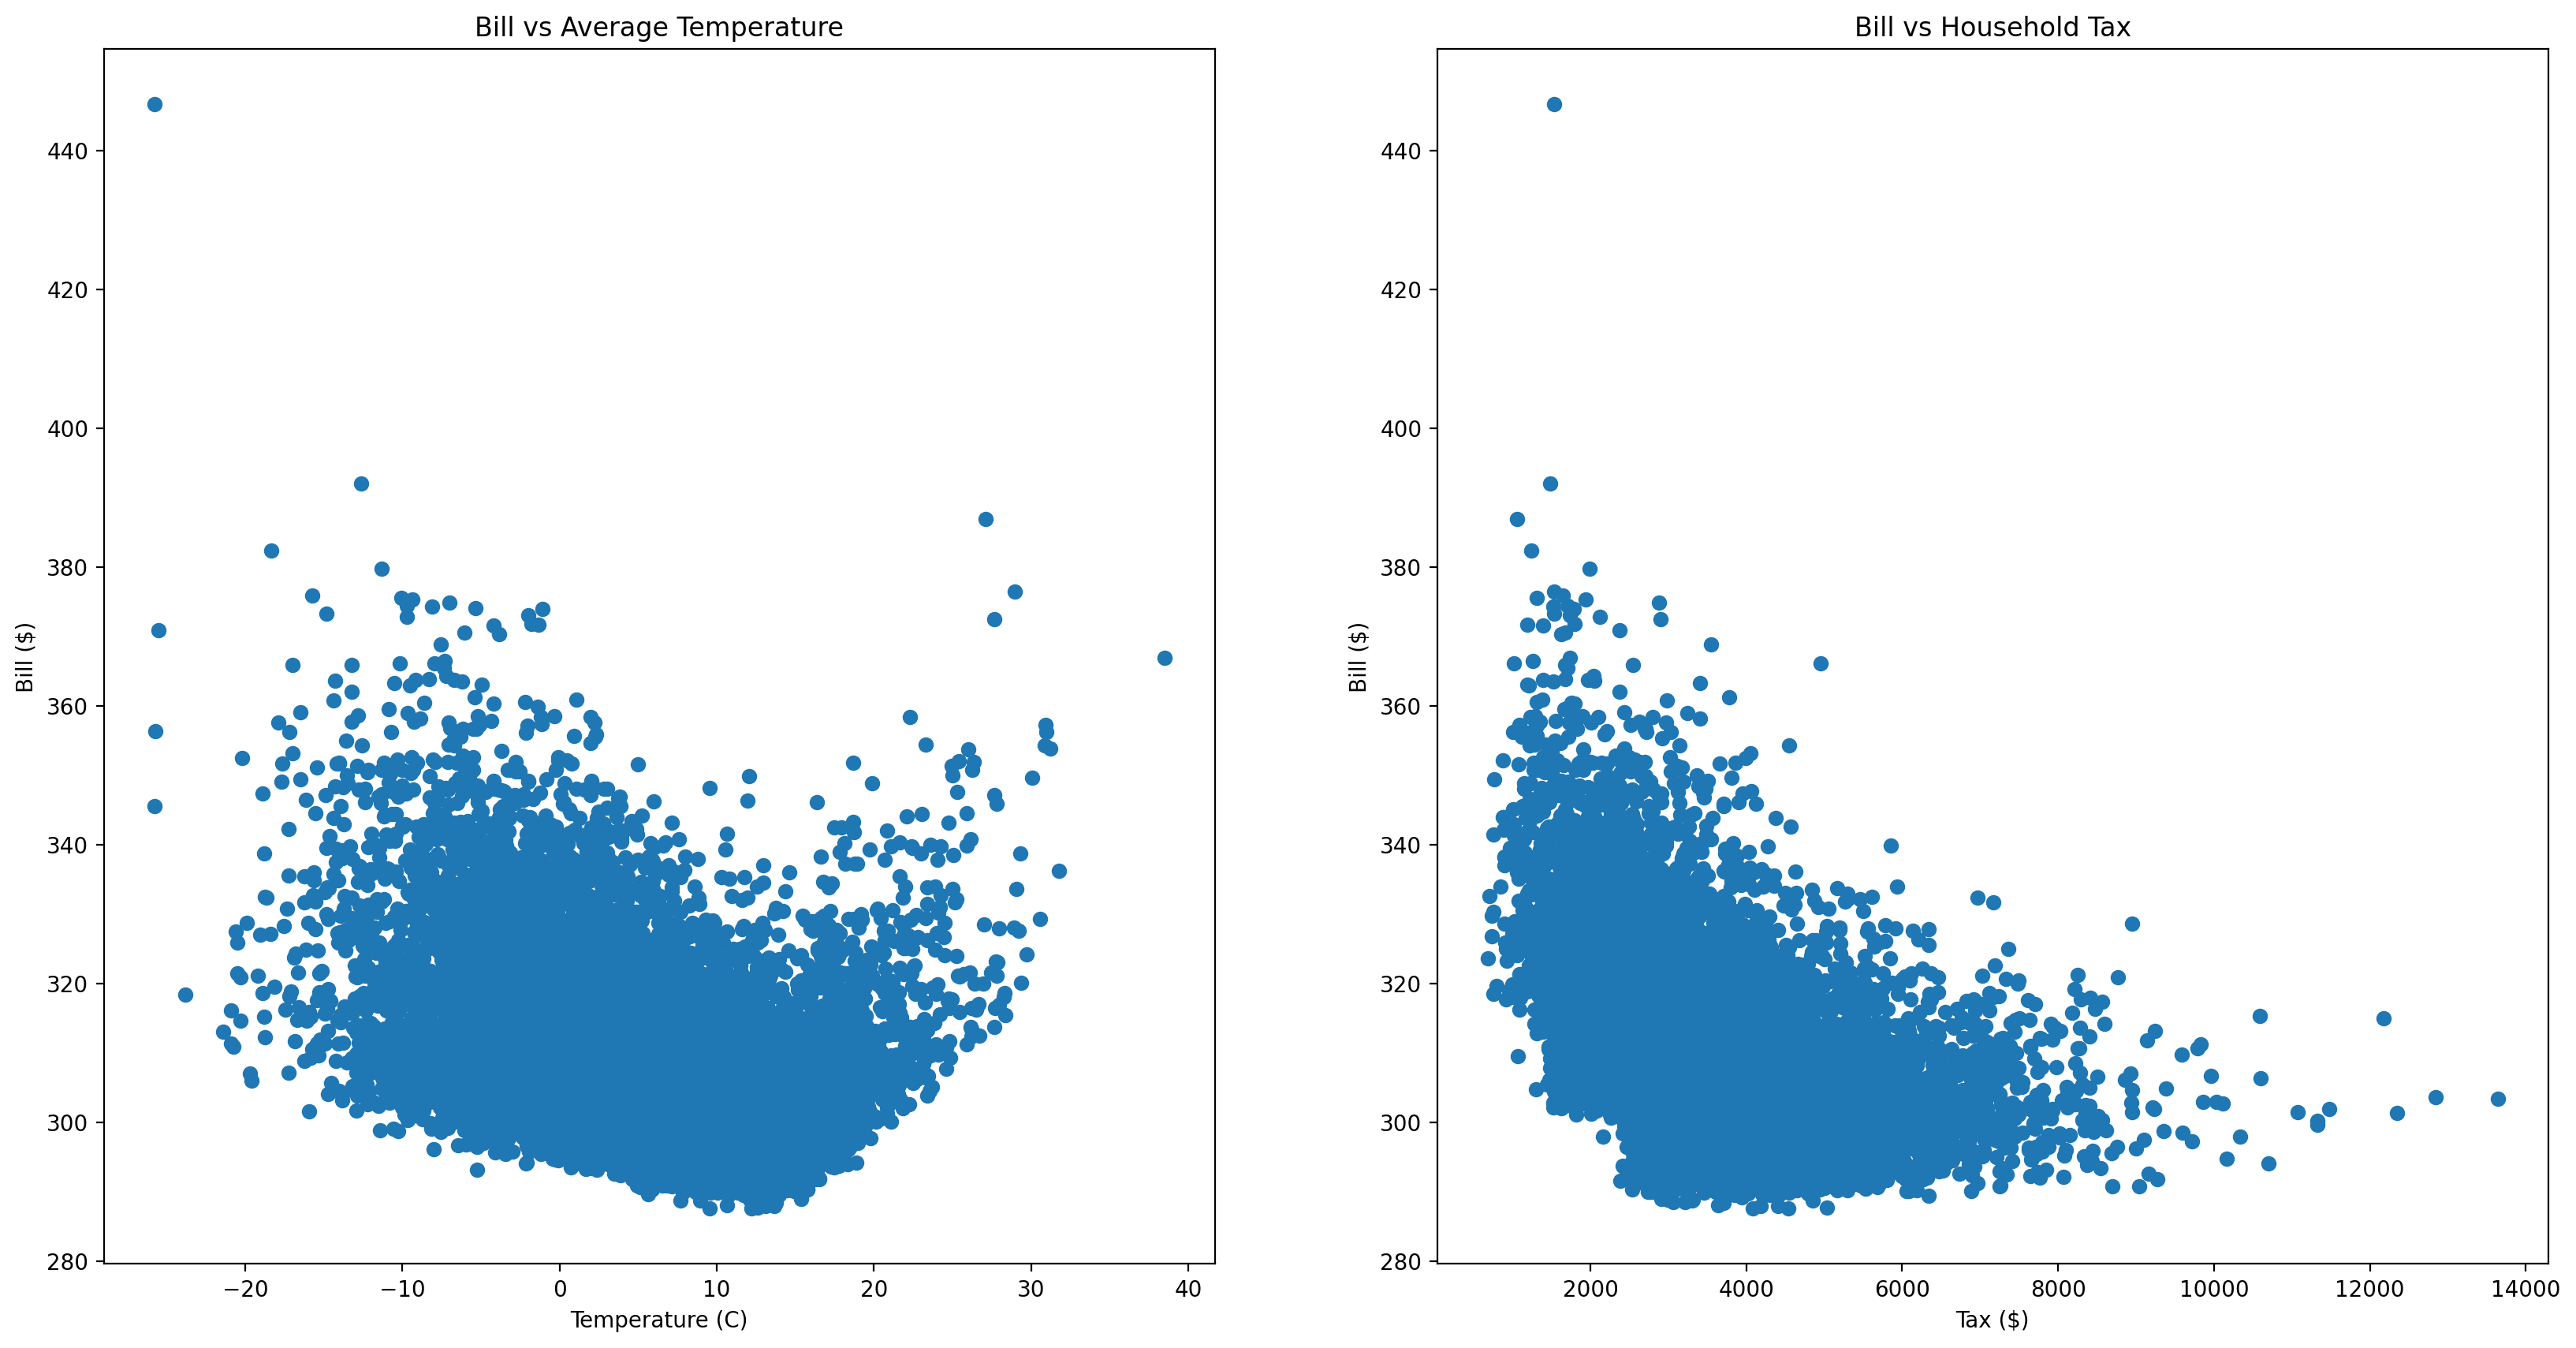

In [84]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot( data['avg_temperature'], data['bill'],'o')
plt.title("Bill vs Average Temperature")
plt.ylabel("Bill ($)")
plt.xlabel("Temperature (C)")
plt.subplot(1,2,2)
plt.plot(data['house_taxes'],data['bill'],  'o')
plt.title("Bill vs Household Tax")
plt.ylabel("Bill ($)")
plt.xlabel("Tax ($)")

## C (10 points)

Preprocess the data by standardizing all predictor variables.

In [112]:
data_std = data.copy()
data_std[['house_taxes','household_size','avg_temperature']] = (data[['house_taxes','household_size','avg_temperature']] - data[['house_taxes','household_size','avg_temperature',]].mean())/data[['house_taxes','household_size','avg_temperature',]].std()
data_std

,avg_temperature,household_size,house_taxes,bill
0,2.044949,1.674701,-0.967602,339.825365
1,1.663465,-0.202955,0.246197,317.335924
2,0.797109,-1.141783,-0.773682,304.327370
3,2.702267,-1.141783,0.792047,316.291108
4,-0.419429,0.735873,1.510271,308.869530
...,...,...,...,...
9995,0.599743,-1.141783,1.352262,295.463720
9996,-1.127677,-0.202955,0.231832,308.811366
9997,0.608057,0.735873,-0.055457,300.816582
9998,-0.138764,-0.202955,0.052276,299.321222


Text(0.5, 0, 'Tax ($)')

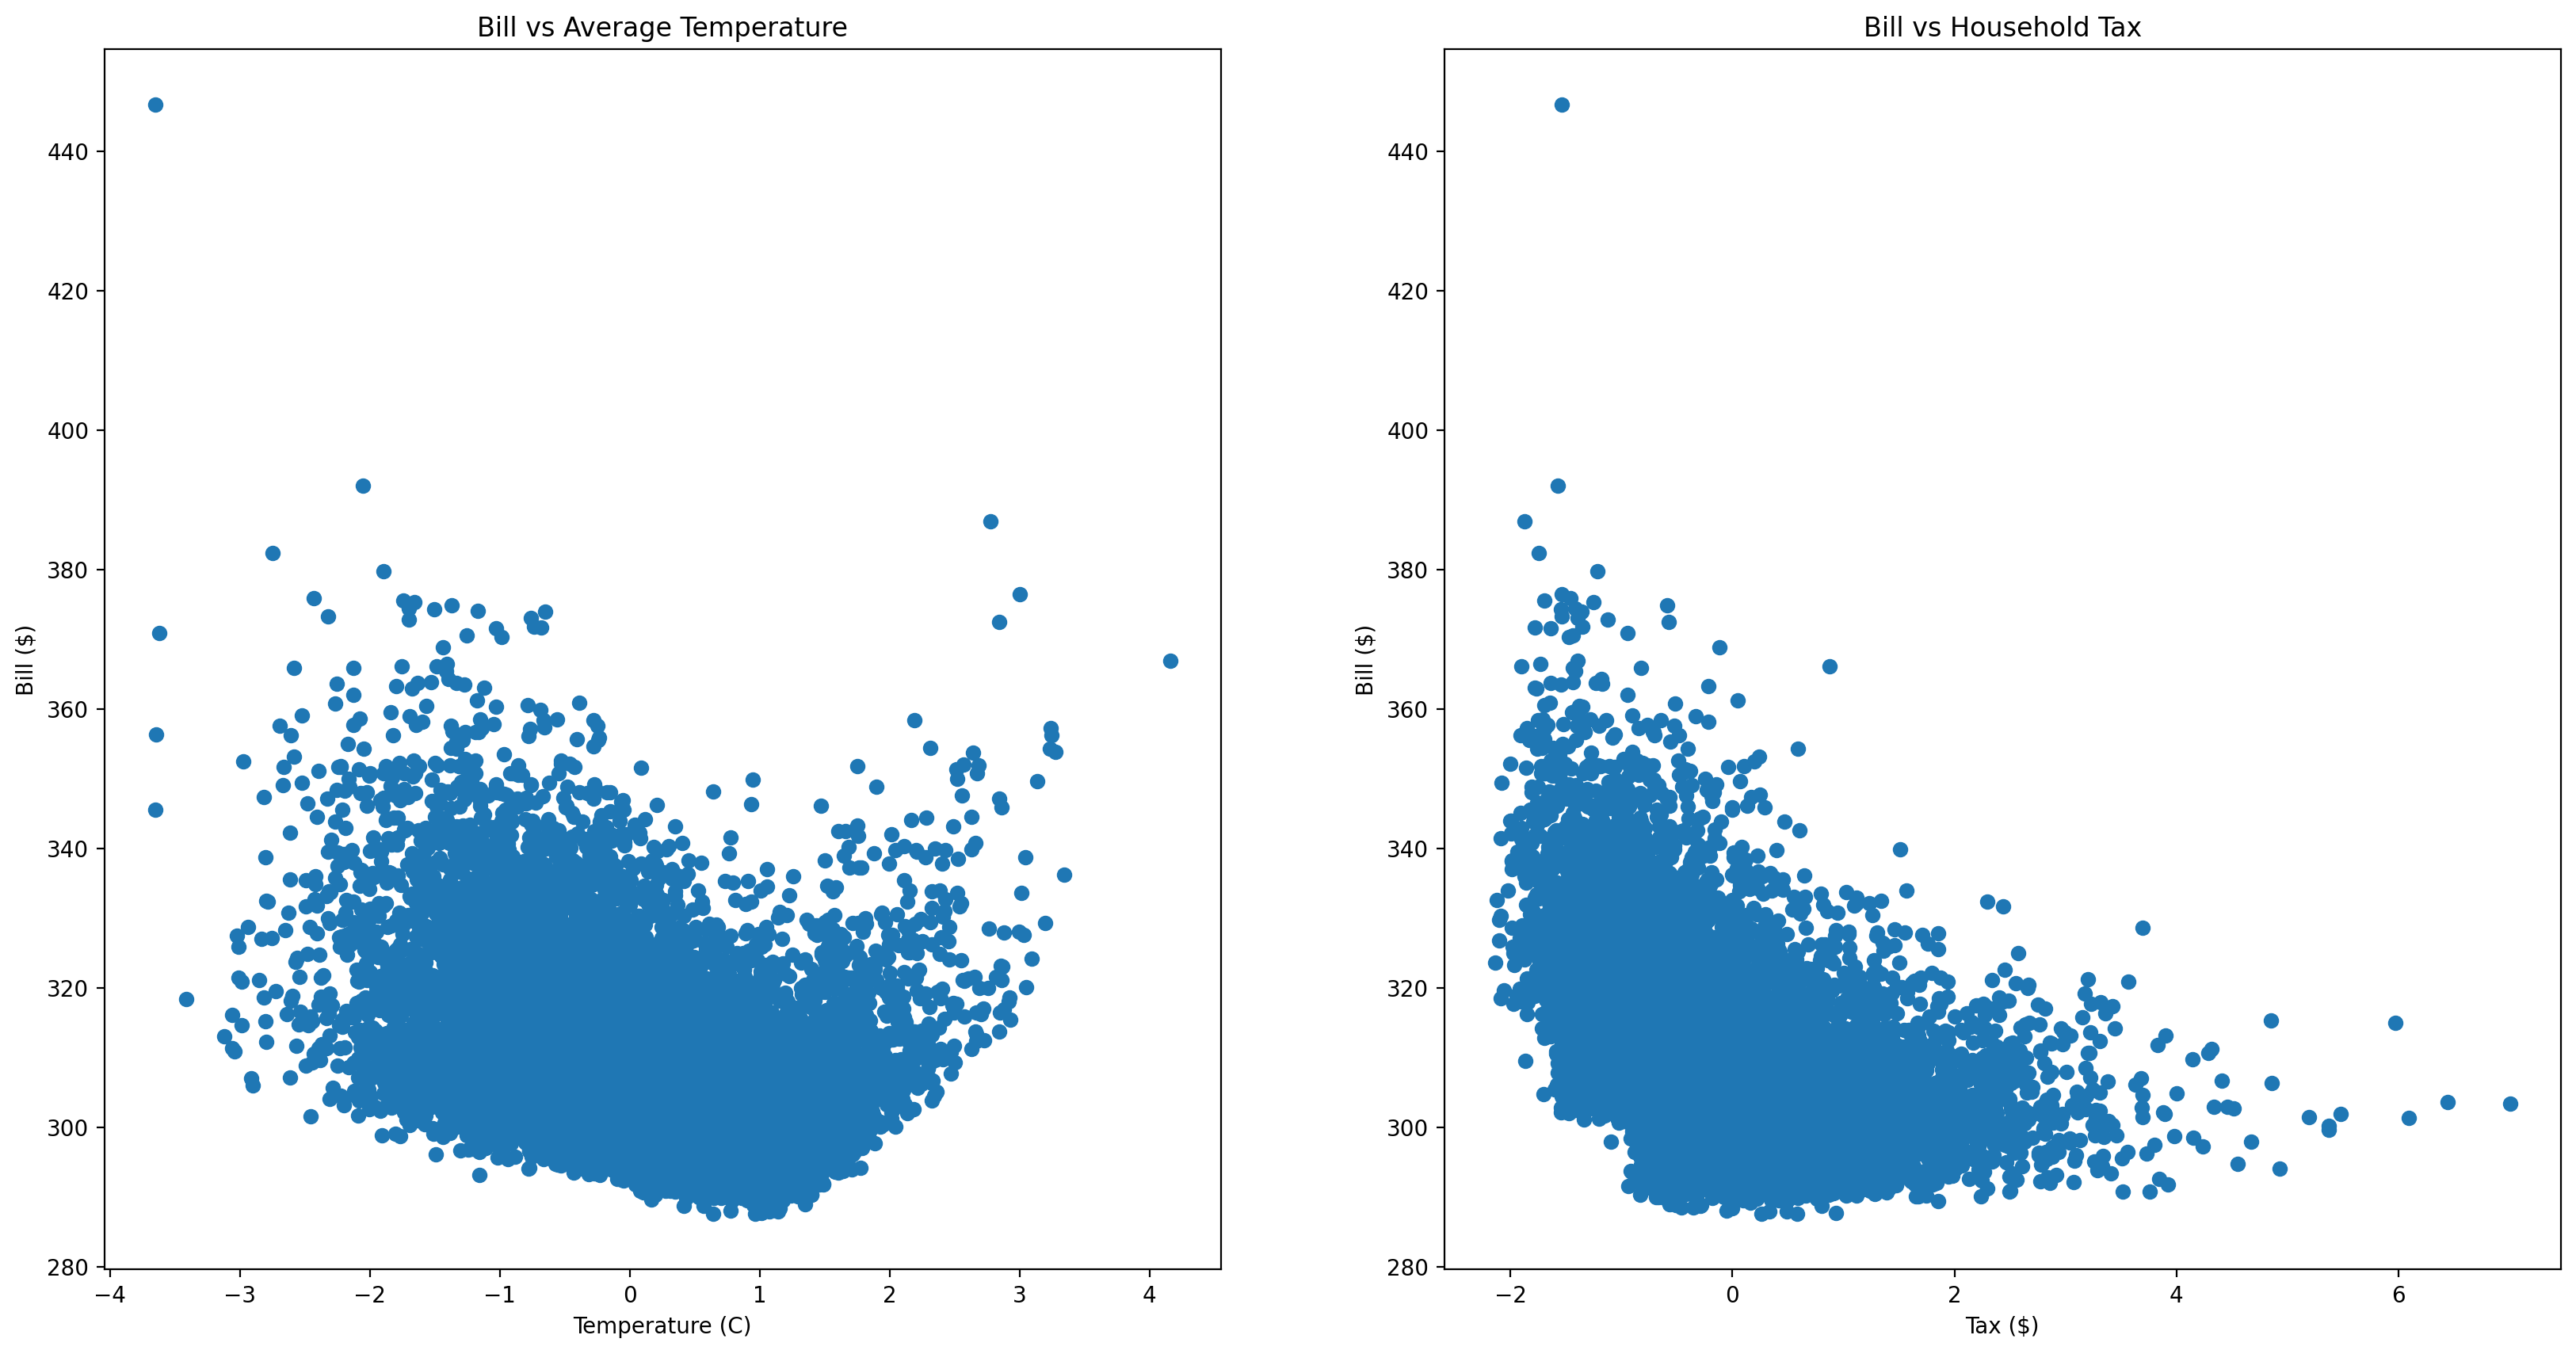

In [139]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot( data_std['avg_temperature'], data_std['bill'],'o')
plt.title("Bill vs Average Temperature")
plt.ylabel("Bill ($)")
plt.xlabel("Temperature (C)")
plt.subplot(1,2,2)
plt.plot(data_std['house_taxes'],data_std['bill'],  'o')
plt.title("Bill vs Household Tax")
plt.ylabel("Bill ($)")
plt.xlabel("Tax ($)")

## D (25 points)

Propose prior distributions for a simple linear model for `bill` using `avg_temperature` and `household_size` as predictors. Create prior predictive plots. Use MCMC sampling (make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 20 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distributions.

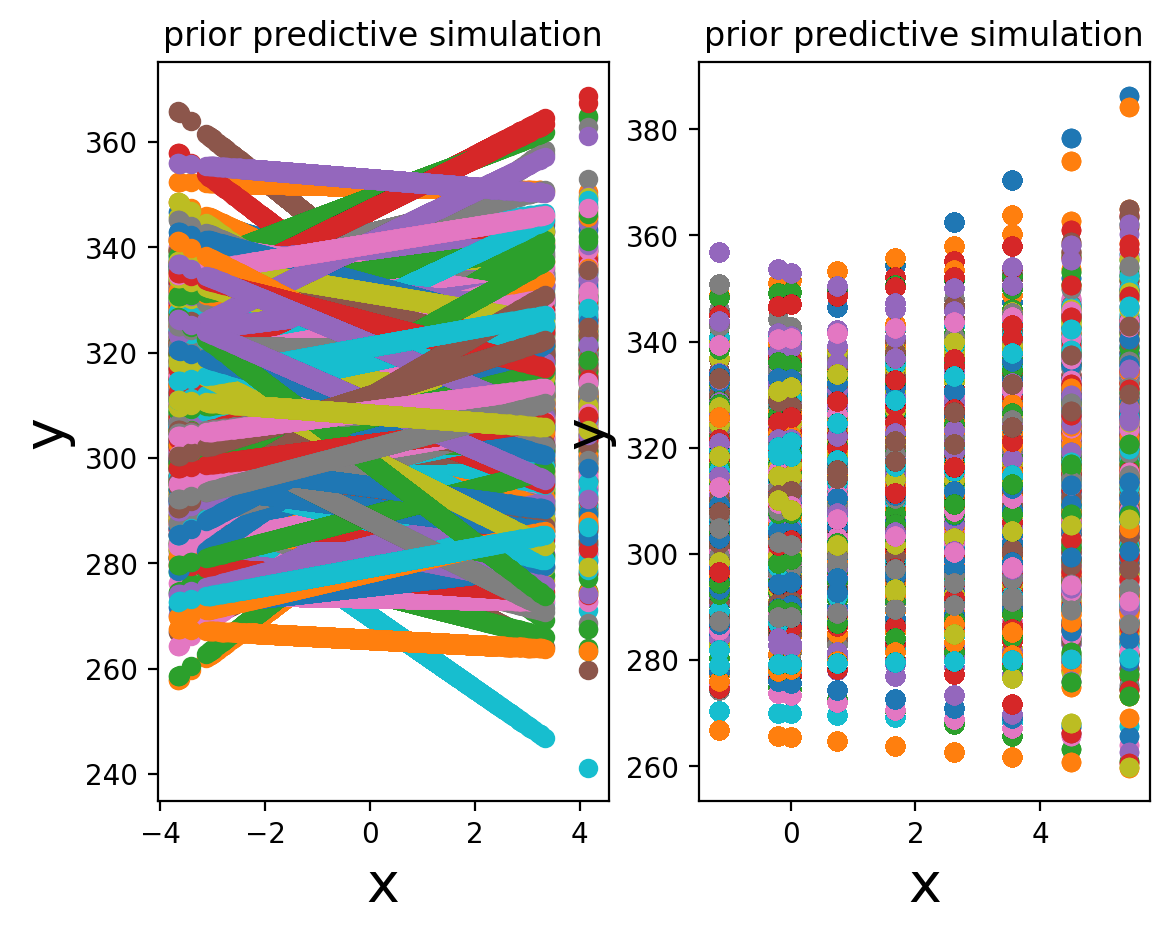

In [150]:
n_samples = 500  # 500 points
sigma =  stats.expon.rvs(1, n_samples)
beta_T = stats.norm.rvs(0, 3, n_samples)
beta_S= stats.norm.rvs(1, 3, n_samples)
alpha = stats.norm.rvs(data_std['bill'].mean(), data_std['bill'].std(),size= n_samples)
average_temp = np.array(data_std['avg_temperature'])
household_size = np.array(data_std['household_size'])
mu = alpha[None, :] + beta_T [None, :]* average_temp[:, None] + beta_S [None, :] * household_size[:, None]
mu_T = alpha[None, :] + beta_T [None, :]* average_temp[:, None]
mu_S = alpha[None, :] + beta_S [None, :] * household_size[:, None]

#Not sure how to plot 2 x variables against reponse in 2D plot. Treated each independently
plt.subplot(1,2,1)
plot(average_temp, mu_T, 'o')
# plt.ylim(-100, 400)
title('prior predictive simulation')
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

plt.subplot(1,2,2)
plot(household_size, mu_S, 'o')
# plt.ylim(-100, 400)
title('prior predictive simulation')
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

In [135]:
with pm.Model() as model_B_TS:
    sigma = pm.Exponential('sigma', 1)
    beta_T = pm.Normal('beta_T', mu=0, sigma=1)
    beta_S = pm.Normal('beta_S', mu=0, sigma=1)
    alpha = pm.Normal('alpha', mu=data_std['bill'].mean(), sigma=data_std['bill'].std())
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    mu = alpha + beta_T*data_std['avg_temperature'] + beta_S*data_std['household_size']
    H = pm.Normal('bill', mu=mu, sigma=sigma, observed=data_std['bill'])
    avg_temperature_samples = stats.norm.rvs(loc=0, scale=1, size=n_samples)
    avg_temperature_samples = stats.norm.rvs(loc=0, scale=1, size=n_samples)
    ## MCMC
    _B_TS_posterior = pm.sample(500, tune=1000, chains=4, cores=2)
B_TS_posterior = _B_TS_posterior.posterior.to_dataframe()



Output()

In [151]:
varnames = ['alpha', 'beta_T', 'beta_S', 'sigma']
display(pm.summary(B_TS_posterior, var_names=varnames))
az.plot_trace(B_TS_posterior, varnames, compact=False, figsize=(8, 1.6*len(varnames)));
az.plot_forest(B_TS_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree (if 'dm-tree' is installed), netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not DataFrame

## E (10 points)

Based on the scatter plot obtained in part B, do you think this is a reasonable model? Interpret the mean of the posterior for each of the parameters. Comment on the relationship between the monthly average temperature and the utility bill amount. How would you approach modeling the utility bill as a function of the average monthly temperature?

## F (20 points)

Extend the linear model by adding `house_taxes` as a predictor. Use MCMC sampling (again, make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 25 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distribution.

## G (10 points)

Interpret the mean of the posterior for the new parameter. Compare the other mean posterior values with those obtained in part E. Based on the scatter plot you obtained in part B, do you think this is a reasonable model? Comment on the relationship between the yearly property taxes and the utility bill amount. What do you think is happening here?